# Import Library

In [ ]:
# Stores Data in Dataframe
import pandas as pd
import numpy as np

# Visualize Data
#import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from keras.utils import to_categorical

# Basic Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Evaluation of Basic Models
from sklearn.metrics import mean_squared_error, r2_score

# Machine Learning Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense, Embedding, LSTM, GRU, Conv1D, MaxPooling1D, SimpleRNN
from keras.layers import Dropout

tf.random.set_seed(42)

# Load Data

In [ ]:
X_train = pd.read_csv("/content/stability.train.csv")
X_valid = pd.read_csv("/content/stability.valid.csv")
X_test = pd.read_csv("/content/stability.test.csv")

In [ ]:
# Drop all NA rows
X_train = X_train.dropna()
X_valid = X_valid.dropna()
X_test = X_test.dropna()

X_train

,seq,label
0,DQSVRKLVRKLPDEGLDREKVKTYLDKLGVDREELQKFSDAIGLES...,-0.21
1,GSSDIEITVEGKEQADKVIEEMKRRNLEVHVEEHNGQYIDKASLES...,-0.95
2,GSSTERRTFDDETQARKAAEEAKKKGLQVTVTKENGQYHVDFN,0.42
3,MLDDFTHELMLDDFTHELMLDDFTHELMLDDFTHELSSNGGGSNGS...,0.10
4,GSSTQTITTTNKENAEQIAREAKKKGLDVTIRKNNGTWEIHWD,0.76
...,...,...
53609,VPGNITDEYIGYSAKEIRYRSMVKISGNGSGGNGSGGNGSGNGSGN...,0.40
53610,DESEKQRRVRKLLKEGNIEEAKRLAEEAGDDDARKEAEKAERS,0.87
53611,GSSTETYTYTDREQAERVAEEAKRRGYTVTIRHENGKWEVRIE,-0.39
53612,RKNPKTKLKKGLEDIDEASIAKWQARRGTNEEAENIGKEADSL,-0.22


In [ ]:
positive_count = (X_train['label'] > 0).sum()  # Count positive numbers
negative_count = (X_train['label'] < 0).sum()  # Count negative numbers

print("Number of positive numbers:", positive_count)
print("Number of negative numbers:", negative_count)

Number of positive numbers: 31903
Number of negative numbers: 21301


# Data Distribution

##### Histogram of Amino Acids and Stability Values

In [ ]:
# Extract the 'sequence' column
sequences = X_train['seq']

# Concatenate all sequences into a single string
all_sequences = ''.join(sequences)

# Count the occurrences of each letter
amino_counts = pd.Series(list(all_sequences)).value_counts()

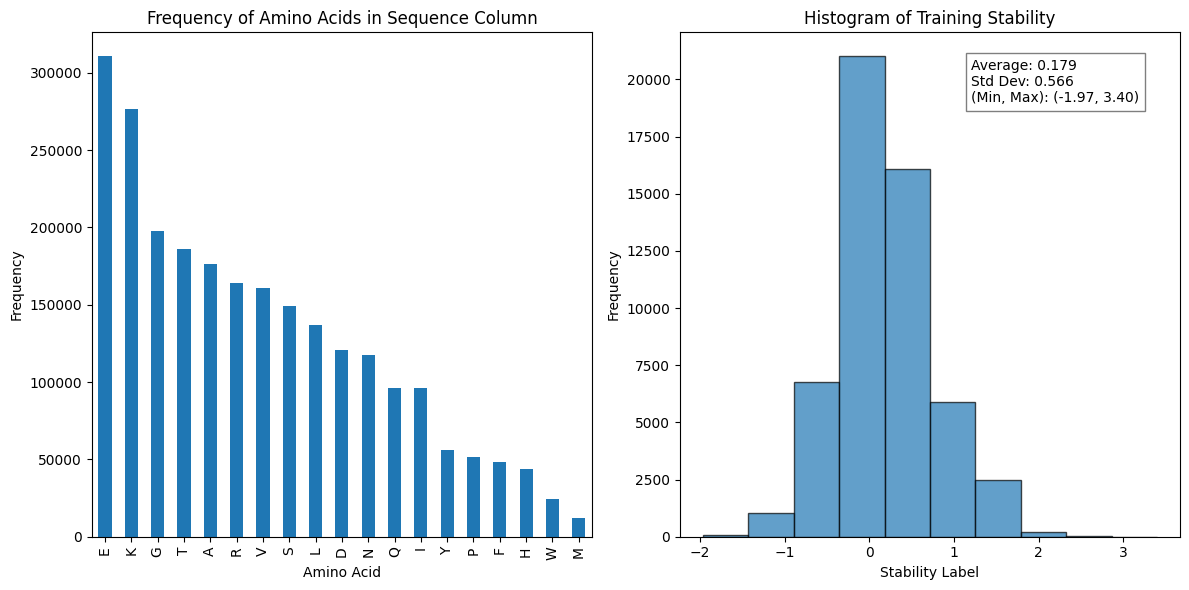

In [ ]:
# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the frequencies of amino acids
amino_counts.plot(kind='bar', ax=ax1)
ax1.set_xlabel('Amino Acid')
ax1.set_ylabel('Frequency')
ax1.set_title('Frequency of Amino Acids in Sequence Column')

# Plot the histogram of class counts
X_train.label.hist(ax=ax2, edgecolor='black', alpha=0.7, grid=False)
ax2.set_xlabel('Stability Label')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Training Stability')
ax2.text(1.2, 19000,
         f'Average: {np.mean(X_train.label):.3f}\nStd Dev: {np.std(X_train.label):.3f}\n(Min, Max): ({np.min(X_train.label):.2f}, {np.max(X_train.label):.2f})',
         fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

##### Histogram of Sequence Lengths

In [ ]:
# Calculate the lengths of sequences
sequence_lengths = X_train['seq'].apply(len)

In [ ]:
unique_numbers, counts = np.unique(sequence_lengths, return_counts=True)
frequency = dict(zip(unique_numbers, counts))
frequency

{43: 36446, 50: 17168}

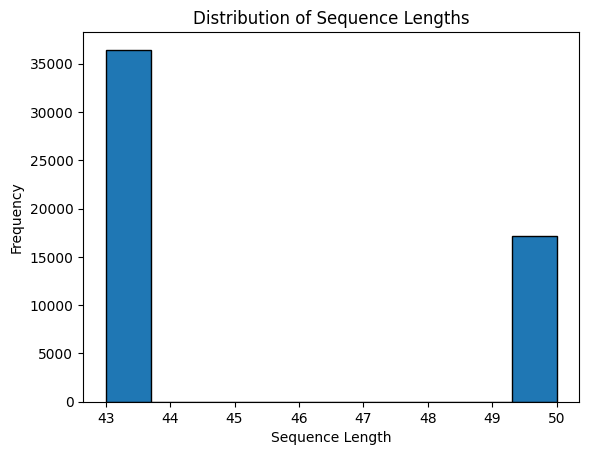

In [ ]:
# Plot the histogram of sequence lengths
plt.hist(sequence_lengths, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

Unfortnately, the protein sequences are only 43 or 50 because the two papers used different proteins. I do not believe it is a problem because the goal of the project is to understand the realtionships of the order of the amino acids sequences. If there was a bigger differnce in the protein sequences for example 10 and 1000, then this would be more concerning.

# Data Preprocessing

##### Encode Sequences of Training Data

In [ ]:
# Create new data frame that holds encoded data
encoded_df_train = X_train
encoded_df_test = X_test
encoded_df_valid = X_valid

In [ ]:
# 19 unique amino acids in the protein sequences
aminos = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Create amino acid dictionary
amino_dict = {amino: i for i, amino in enumerate(aminos)}

print(amino_dict, "\n")

print(X_train.head(2), "\n")

# Encode each amino acid in the sequences
encoded_df_train['seq'] = X_train['seq'].apply(lambda seq: [amino_dict.get(code, 0) for code in seq])
print(encoded_df_train.head(2))

{'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19} 

                                                 seq  label
0  DQSVRKLVRKLPDEGLDREKVKTYLDKLGVDREELQKFSDAIGLES...  -0.21
1  GSSDIEITVEGKEQADKVIEEMKRRNLEVHVEEHNGQYIDKASLES...  -0.95 

                                                 seq  label
0  [2, 13, 15, 17, 14, 8, 9, 17, 14, 8, 9, 12, 2,...  -0.21
1  [5, 15, 15, 2, 7, 3, 7, 16, 17, 3, 5, 8, 3, 13...  -0.95


##### Add Padding to Sequences

In [ ]:
# Function to do padding on the sequences
def padding(df):
  # Set the maximum length for padding
  max_length = 50

  # Convert the sequences in df to a list
  sequences = df['seq'].tolist()

  # Pad sequences to ensure they all have the same length
  padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
  padded_sequences_df = pd.DataFrame(padded_sequences)

  return padded_sequences_df.values.tolist()

In [ ]:
encoded_df_train["seq"] = padding(encoded_df_train)

# Now padded_sequences contains your sequences with a fixed length of 50
print("Shape of padded sequences:", encoded_df_train.seq.shape)

Shape of padded sequences: (53614,)


In [ ]:
encoded_df_train.head()

,seq,label
0,"[2, 13, 15, 17, 14, 8, 9, 17, 14, 8, 9, 12, 2,...",-0.21
1,"[5, 15, 15, 2, 7, 3, 7, 16, 17, 3, 5, 8, 3, 13...",-0.95
2,"[5, 15, 15, 16, 3, 14, 14, 16, 4, 2, 2, 3, 16,...",0.42
3,"[10, 9, 2, 2, 4, 16, 6, 3, 9, 10, 9, 2, 2, 4, ...",0.10
4,"[5, 15, 15, 16, 13, 16, 7, 16, 16, 16, 11, 8, ...",0.76


##### Encode and Pad Test and Validation Data

In [ ]:
# Encode and pad test encoding dataframe
encoded_df_test['seq'] = X_test['seq'].apply(lambda seq: [amino_dict.get(code, 0) for code in seq])
encoded_df_test["seq"] = padding(encoded_df_test)

# Encode and pad validation encoding dataframe
encoded_df_valid['seq'] = X_valid['seq'].apply(lambda seq: [amino_dict.get(code, 0) for code in seq])
encoded_df_valid["seq"] = padding(encoded_df_valid)

In [ ]:
# Round each stability score to 4 to make it more readable
encoded_df_train["label"] = round(encoded_df_train["label"], 4)
encoded_df_test["label"] = round(encoded_df_test["label"], 4)
encoded_df_valid["label"] = round(encoded_df_valid["label"], 4)

##### Encoding Stability Scores

Stability Score x\
$x<0$ $\implies$ the protein sequence is less resistant to protease cleavage compared to its unfolded state\
$x > 0$ $\implies$ the protein sequence is more stable under the experimental conditions compared to its unfolded state\


*   $x \leq -1$ : Highly Unstable
*   $-1 < x \leq -0.5$ : Increasingly Unstable
*   $-0.5 < x \leq 0$ : Moderately Unstable
*   $0 < x \leq 0.5$ : Moderately Stable
*   $0.5 < x \leq 1$ : Increasingly Stable
*   $1 < x \leq 1.5$ : Highly Stable
*   $x > 1.5$ : Extremely Stable


In [ ]:
# Encoding function that classifies stability scores
def encode_stability(df):
  # Assuming df is your DataFrame
  for index, row in df.iterrows():
      # Modify the value in the second column (index 1)
      stability_score = row[1]
      if stability_score > 1.5:
        df.at[index, "label"] = 0
      elif stability_score > 1 and stability_score <= 1.5:
        df.at[index, "label"] = 1
      elif stability_score > 0.5 and stability_score <= 1:
        df.at[index, "label"] = 2
      elif stability_score > 0 and stability_score <= 0.5:
        df.at[index, "label"] = 3
      elif stability_score > -0.5 and stability_score <= 0:
        df.at[index, "label"] = 4
      elif stability_score > -1 and stability_score <= -0.5:
        df.at[index, "label"] = 5
      else:
        df.at[index, "label"] = 6

In [ ]:
# Classify each stability score
encode_stability(encoded_df_train)
encode_stability(encoded_df_test)
encode_stability(encoded_df_valid)

In [ ]:
encoded_df_train.head()

,seq,label
0,"[2, 13, 15, 17, 14, 8, 9, 17, 14, 8, 9, 12, 2,...",4.0
1,"[5, 15, 15, 2, 7, 3, 7, 16, 17, 3, 5, 8, 3, 13...",5.0
2,"[5, 15, 15, 16, 3, 14, 14, 16, 4, 2, 2, 3, 16,...",3.0
3,"[10, 9, 2, 2, 4, 16, 6, 3, 9, 10, 9, 2, 2, 4, ...",3.0
4,"[5, 15, 15, 16, 13, 16, 7, 16, 16, 16, 11, 8, ...",2.0


###### Histogram of Each Stability Class
Each historgram shows there is a reasonably good distribution of data for each stability class.

(array([ 1102.,  3818.,  8023., 18960., 16863.,  4848.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

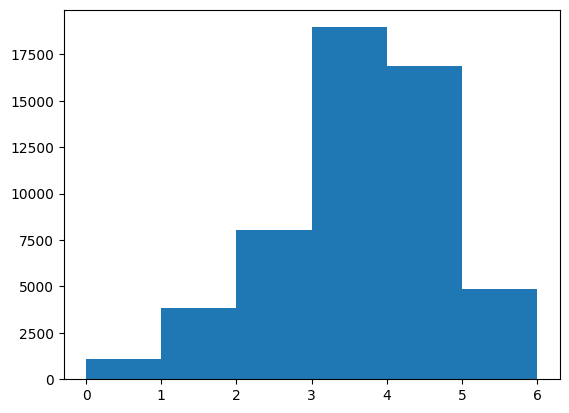

In [ ]:
plt.hist(encoded_df_train.label, bins=range(7))

(array([114., 306., 399., 726., 713., 254.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

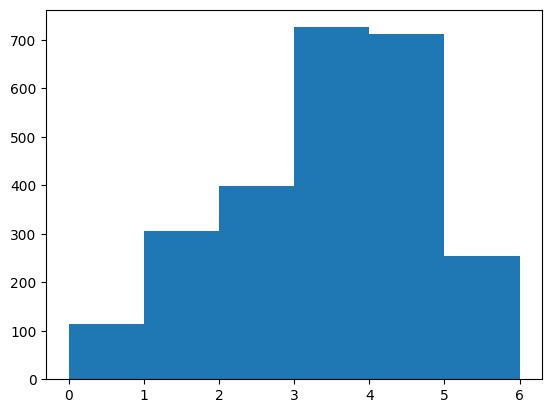

In [ ]:
plt.hist(encoded_df_valid.label, bins=range(7))

(array([1673., 4651., 5094., 1375.,   58.,    0.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

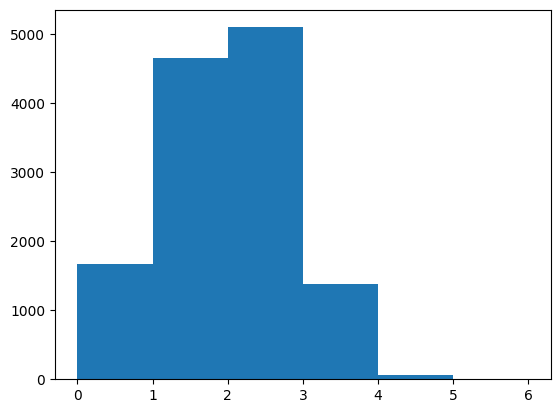

In [ ]:
plt.hist(encoded_df_test.label, bins=range(7))

##### One Hot Encoding of Stability Classes
I do not use this but it is useful if you want to do it for later testing.

In [ ]:
# One hot encoding of label
# Example
# Class 0: [1, 0, 0, 0, 0, 0, 0] = Extremely Stable
# Class 1: [0, 1, 0, 0, 0, 0, 0] = Highly Stable
# Class 2: [0, 0, 1, 0, 0, 0, 0] = Increasingly Stable
# ...
# Class 6: [0, 0, 0, 0, 0, 0, 1] = Highly Unstable
y_train = to_categorical(encoded_df_train["label"])
y_valid = to_categorical(encoded_df_valid["label"])
y_test = to_categorical(encoded_df_test["label"])
y_train.shape, y_valid.shape, y_test.shape

((53614, 7), (2512, 7), (12851, 5))

In [ ]:
y_train[0]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

Traditional Models

Originally, I wanted to see if traditional models can predict the actual value of the stability score. I

Four Models

# Linear Regression



In [ ]:
X_train.label[:]

0        4.0
1        5.0
2        3.0
3        3.0
4        2.0
        ... 
53609    3.0
53610    2.0
53611    4.0
53612    4.0
53613    1.0
Name: label, Length: 53614, dtype: float64

In [ ]:
# Initialize and train the linear regression model
lr = LinearRegression()
lr.fit(X_train['seq'].tolist(), X_train['label'])


LinearRegression()

In [ ]:
coefficients = lr.coef_
print("Coefficients:", len(coefficients))

Coefficients: 50


In [ ]:
# Predict the labels using the trained linear regression model
y_pred_lr = lr.predict(X_valid['seq'].tolist())

# Calculate mean squared error
mse_lr = mean_squared_error(X_valid['label'], y_pred_lr)
r2_lr = r2_score(X_valid['label'], y_pred_lr)

print(f"Mean Squared Error: {mse_lr:.4f}")
print(f"R-squared: {r2_lr:.4f}")

Mean Squared Error: 1.6097
R-squared: 0.1011


# Decision Tree

I continue to see if if traditional models can predict the actual value of the stability score.

In [ ]:
# Initialize and train the linear regression model
dt = DecisionTreeRegressor()
dt.fit(X_train['seq'].tolist(), X_train['label'])

DecisionTreeRegressor()

In [ ]:
# Predict the labels using the trained linear regression model
y_pred_dt = dt.predict(X_valid['seq'].tolist())

# Calculate mean squared error
mse_dt = mean_squared_error(X_valid['label'], y_pred_dt)
r2_dt = r2_score(X_valid['label'], y_pred_dt)

print(f"Mean Squared Error: {mse_dt:.4f}")
print(f"R-squared: {r2_dt:.4f}")

Mean Squared Error: 1.8778
R-squared: -0.0486


# Random Forest

The last model I looked at was a random forrest.

In [ ]:
# Initialize and train the linear regression model
rf = RandomForestRegressor()
rf.fit(X_train['seq'].tolist(), X_train['label'])

RandomForestRegressor()

In [ ]:
# Predict the labels using the trained linear regression model
y_pred_rf = rf.predict(X_valid['seq'].tolist())

# Calculate mean squared error, r2, and accuracy
mse_rf = mean_squared_error(X_valid['label'], y_pred_rf)
r2_rf = r2_score(X_valid['label'], y_pred_rf)

print(f"Mean Squared Error: {mse_rf:.4f}")
print(f"R-squared: {r2_rf:.4f}")

Mean Squared Error: 0.9195
R-squared: 0.4865


# Support Vector Regression

In [ ]:
# Initialize and train the linear regression model
svr = SVR()
svr.fit(X_train['seq'].tolist(), X_train['label'])

SVR()

In [ ]:
# Predict the labels using the trained linear regression model
y_pred_svr = svr.predict(X_valid['seq'].tolist())

# Calculate mean squared error, r2, and accuracy
mse_svr = mean_squared_error(X_valid['label'], y_pred_svr)
r2_svr = r2_score(X_valid['label'], y_pred_svr)

print(f"Mean Squared Error: {mse_svr:.4f}")
print(f"R-squared: {r2_svr:.4f}")

Mean Squared Error: 1.2164
R-squared: 0.3208


# Evaluation of First Four Models


In [ ]:
eval = {
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Support Vector Regression'],
    'MSE': [mse_lr, mse_dt, mse_rf, mse_svr],
    'R-squared': [r2_lr, r2_dt, r2_rf, r2_svr]
}

# Create the DataFrame
df_eval = pd.DataFrame(eval)

df_eval

,Model,MSE,R-squared
0,Linear Regression,1.609678,0.101131
1,Decision Tree,1.877787,-0.048585
2,Random Forest,0.919525,0.486523
3,Support Vector Regression,1.216362,0.320765


# Simple DNN

In [ ]:
# Plot Loss Curve and Accuracy Curve
def plot(history, name_model):

  # Plot Loss and Accuracy
  plt.figure(figsize=(12, 5))

  # Loss Plot
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss Cruve of ' + name_model)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Accuracy Plot
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy Curve of ' + name_model)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
dnn1 = Sequential([
    Flatten(input_shape=(50,)),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(124, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile the model
dnn1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model with early stopping
history1 = dnn1.fit(encoded_df_train['seq'].tolist(), encoded_df_train['label'].tolist(),
                     epochs=100, batch_size=32,
                     validation_data=(encoded_df_valid['seq'].tolist(), encoded_df_valid['label'].tolist()),
                     callbacks=[early_stopping])


Epoch 1/100
1676/1676 [==============================] - 27s 16ms/step - loss: 1.4467 - accuracy: 0.3692 - val_loss: 1.5032 - val_accuracy: 0.3404
Epoch 2/100
1676/1676 [==============================] - 27s 16ms/step - loss: 1.4135 - accuracy: 0.3808 - val_loss: 1.5329 - val_accuracy: 0.3491
Epoch 3/100
1676/1676 [==============================] - 24s 14ms/step - loss: 1.3986 - accuracy: 0.3899 - val_loss: 1.5008 - val_accuracy: 0.3324
Epoch 4/100
1676/1676 [==============================] - 25s 15ms/step - loss: 1.3841 - accuracy: 0.3995 - val_loss: 1.4767 - val_accuracy: 0.3611
Epoch 5/100
1676/1676 [==============================] - 23s 14ms/step - loss: 1.3727 - accuracy: 0.4047 - val_loss: 1.4637 - val_accuracy: 0.3682
Epoch 6/100
1676/1676 [==============================] - 45s 27ms/step - loss: 1.3616 - accuracy: 0.4035 - val_loss: 1.4656 - val_accuracy: 0.3674
Epoch 7/100
1676/1676 [==============================] - 40s 24ms/step - loss: 1.3510 - accuracy: 0.4096 - val_loss: 1

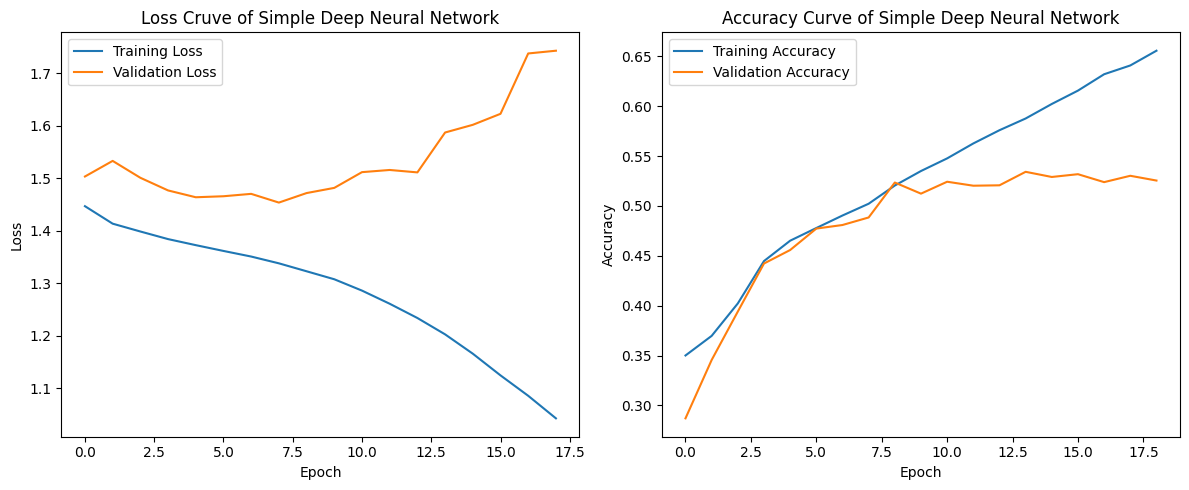

In [ ]:
plot(history1, "Simple Deep Neural Network")

# Deeper DNN

In [ ]:
dnn2 = Sequential([
    Flatten(input_shape=(50,)),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Add dropout with a dropout rate of 0.5
    Dense(124, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile the model
dnn2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model with early stopping
history2 = dnn2.fit(encoded_df_train['seq'].tolist(), encoded_df_train['label'].tolist(),
                     epochs=100, batch_size=32,
                     validation_data=(encoded_df_valid['seq'].tolist(), encoded_df_valid['label'].tolist()),
                     callbacks=[early_stopping])


Epoch 1/100
1676/1676 [==============================] - 29s 16ms/step - loss: 1.4959 - accuracy: 0.3602 - val_loss: 1.5762 - val_accuracy: 0.3252
Epoch 2/100
1676/1676 [==============================] - 27s 16ms/step - loss: 1.4313 - accuracy: 0.3785 - val_loss: 1.5312 - val_accuracy: 0.3368
Epoch 3/100
1676/1676 [==============================] - 28s 16ms/step - loss: 1.4169 - accuracy: 0.3851 - val_loss: 1.5559 - val_accuracy: 0.3364
Epoch 4/100
1676/1676 [==============================] - 26s 16ms/step - loss: 1.4066 - accuracy: 0.3890 - val_loss: 1.5477 - val_accuracy: 0.3404
Epoch 5/100
1676/1676 [==============================] - 28s 16ms/step - loss: 1.4023 - accuracy: 0.3890 - val_loss: 1.5034 - val_accuracy: 0.3471
Epoch 6/100
1676/1676 [==============================] - 26s 15ms/step - loss: 1.3951 - accuracy: 0.3915 - val_loss: 1.4910 - val_accuracy: 0.3798
Epoch 7/100
1676/1676 [==============================] - 35s 21ms/step - loss: 1.3864 - accuracy: 0.3937 - val_loss: 1

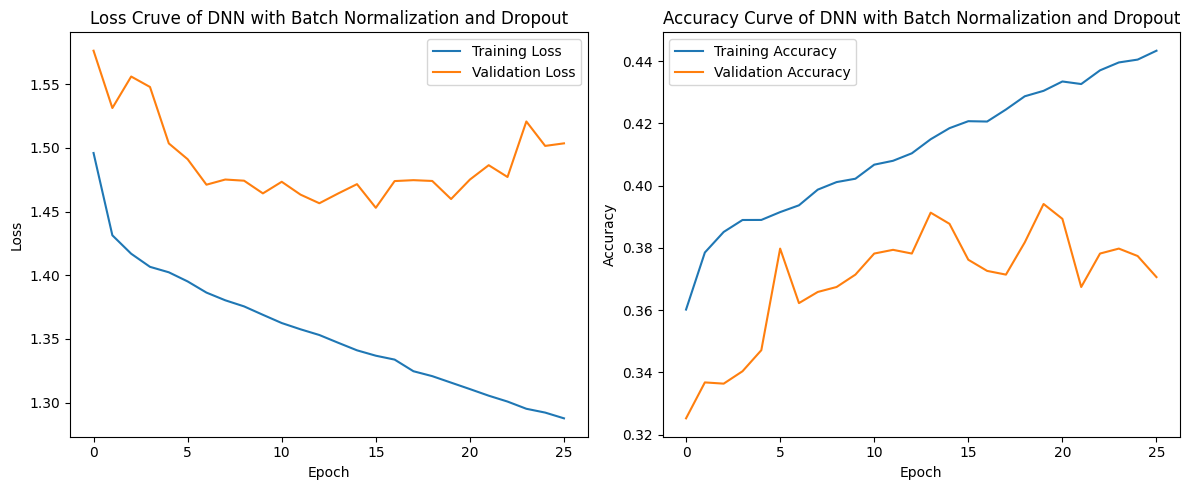

In [ ]:
plot(history2, "DNN with Batch Normalization and Dropout")

# Simple LSTM

In [ ]:
# len(amino_dict) = vocab_size
# input_length = max_length
lstm1 = Sequential([
    Embedding(input_dim=len(amino_dict), output_dim=32, input_length=50),
    LSTM(128),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile the model
lstm1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model with early stopping
history3 = lstm1.fit(encoded_df_train['seq'].tolist(), encoded_df_train['label'].tolist(),
                     epochs=100, batch_size=32,
                     validation_data=(encoded_df_valid['seq'].tolist(), encoded_df_valid['label'].tolist()),
                     callbacks=[early_stopping])

Epoch 1/100
1676/1676 [==============================] - 142s 83ms/step - loss: 1.5128 - accuracy: 0.3501 - val_loss: 1.6428 - val_accuracy: 0.2870
Epoch 2/100
1676/1676 [==============================] - 134s 80ms/step - loss: 1.4430 - accuracy: 0.3697 - val_loss: 1.4744 - val_accuracy: 0.3455
Epoch 3/100
1676/1676 [==============================] - 130s 77ms/step - loss: 1.3733 - accuracy: 0.4023 - val_loss: 1.4071 - val_accuracy: 0.3941
Epoch 4/100
1676/1676 [==============================] - 132s 79ms/step - loss: 1.3154 - accuracy: 0.4447 - val_loss: 1.3254 - val_accuracy: 0.4423
Epoch 5/100
1676/1676 [==============================] - 129s 77ms/step - loss: 1.2732 - accuracy: 0.4652 - val_loss: 1.2841 - val_accuracy: 0.4558
Epoch 6/100
1676/1676 [==============================] - 126s 75ms/step - loss: 1.2398 - accuracy: 0.4779 - val_loss: 1.2347 - val_accuracy: 0.4773
Epoch 7/100
1676/1676 [==============================] - 130s 78ms/step - loss: 1.2107 - accuracy: 0.4904 - val_

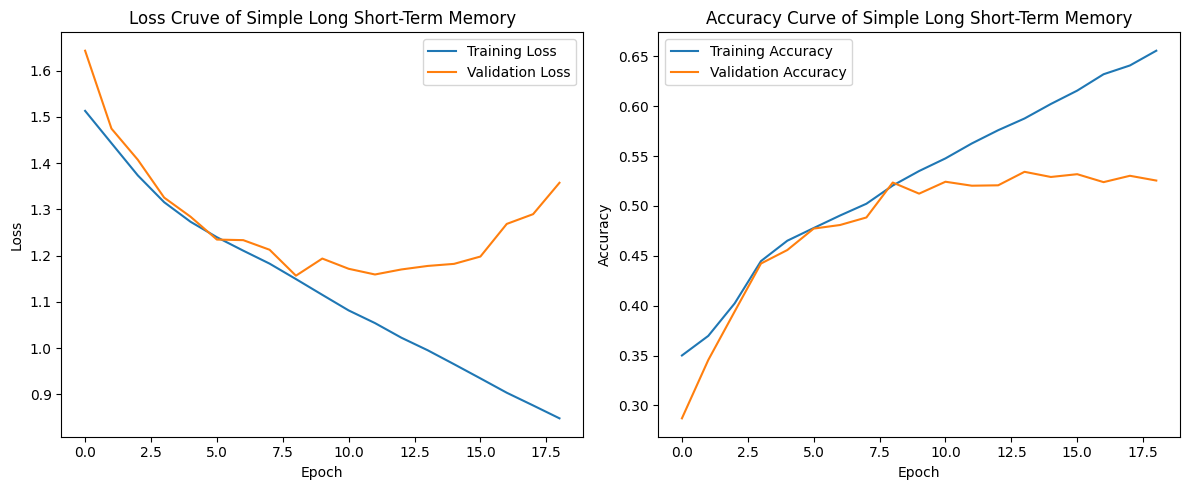

In [ ]:
plot(history3, "Simple Long Short-Term Memory")

# Simple GRU

In [ ]:
# len(amino_dict) = vocab_size
# input_length = max_length
gru1 = Sequential([
    Embedding(input_dim=len(amino_dict), output_dim=32, input_length=50),
    GRU(128),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile the model
gru1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model with early stopping
history4 = gru1.fit(encoded_df_train['seq'].tolist(), encoded_df_train['label'].tolist(),
                     epochs=100, batch_size=32,
                     validation_data=(encoded_df_valid['seq'].tolist(), encoded_df_valid['label'].tolist()),
                     callbacks=[early_stopping])

Epoch 1/100
1676/1676 [==============================] - 98s 57ms/step - loss: 1.5042 - accuracy: 0.3509 - val_loss: 1.6112 - val_accuracy: 0.2954
Epoch 2/100
1676/1676 [==============================] - 90s 54ms/step - loss: 1.4020 - accuracy: 0.3861 - val_loss: 1.4278 - val_accuracy: 0.3897
Epoch 3/100
1676/1676 [==============================] - 90s 53ms/step - loss: 1.3322 - accuracy: 0.4331 - val_loss: 1.3334 - val_accuracy: 0.4323
Epoch 4/100
1676/1676 [==============================] - 92s 55ms/step - loss: 1.2653 - accuracy: 0.4670 - val_loss: 1.2504 - val_accuracy: 0.4745
Epoch 5/100
1676/1676 [==============================] - 91s 54ms/step - loss: 1.2124 - accuracy: 0.4905 - val_loss: 1.2175 - val_accuracy: 0.4821
Epoch 6/100
1676/1676 [==============================] - 92s 55ms/step - loss: 1.1729 - accuracy: 0.5075 - val_loss: 1.2047 - val_accuracy: 0.5004
Epoch 7/100
1676/1676 [==============================] - 89s 53ms/step - loss: 1.1389 - accuracy: 0.5242 - val_loss: 1

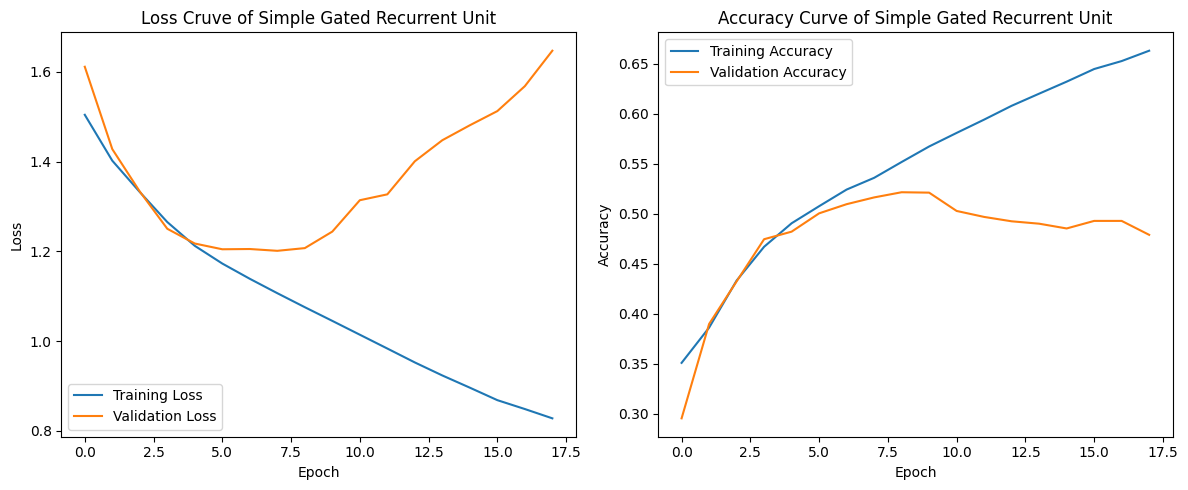

In [ ]:
plot(history4, "Simple Gated Recurrent Unit")

# Simple 1D CNN

In [ ]:
cnn1 = Sequential([
    Embedding(input_dim=len(amino_dict), output_dim=32, input_length=50),
    Conv1D(64, kernel_size=2, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    MaxPooling1D(),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile the model
cnn1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model with early stopping
history5 = cnn1.fit(encoded_df_train['seq'].tolist(), encoded_df_train['label'].tolist(),
                     epochs=100, batch_size=32,
                     validation_data=(encoded_df_valid['seq'].tolist(), encoded_df_valid['label'].tolist()),
                     callbacks=[early_stopping])

Epoch 1/100
1676/1676 [==============================] - 16s 9ms/step - loss: 1.6831 - accuracy: 0.3508 - val_loss: 1.7378 - val_accuracy: 0.2890
Epoch 2/100
1676/1676 [==============================] - 13s 8ms/step - loss: 1.5475 - accuracy: 0.3510 - val_loss: 1.7383 - val_accuracy: 0.2890
Epoch 3/100
1676/1676 [==============================] - 13s 8ms/step - loss: 1.5474 - accuracy: 0.3508 - val_loss: 1.7385 - val_accuracy: 0.2890
Epoch 4/100
1676/1676 [==============================] - 13s 8ms/step - loss: 1.5269 - accuracy: 0.3540 - val_loss: 1.6327 - val_accuracy: 0.3041
Epoch 5/100
1676/1676 [==============================] - 15s 9ms/step - loss: 1.4818 - accuracy: 0.3677 - val_loss: 1.5955 - val_accuracy: 0.3173
Epoch 6/100
1676/1676 [==============================] - 13s 8ms/step - loss: 1.4604 - accuracy: 0.3766 - val_loss: 1.5527 - val_accuracy: 0.3372
Epoch 7/100
1676/1676 [==============================] - 13s 8ms/step - loss: 1.4381 - accuracy: 0.3832 - val_loss: 1.5074 -

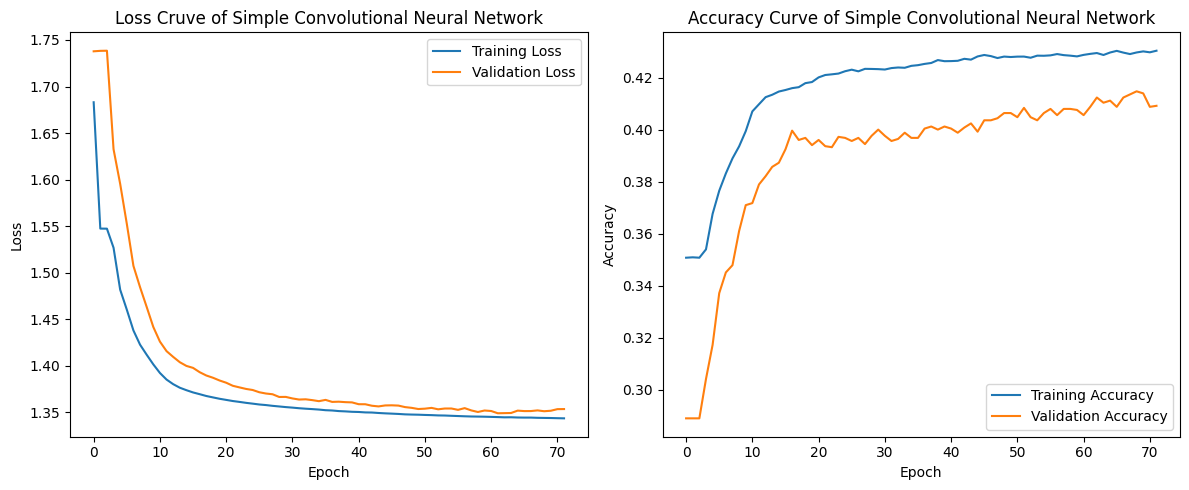

In [ ]:
plot(history5, "Simple Convolutional Neural Network")

# Deeper 1D CNN

In [ ]:
cnn2 = Sequential([
    Embedding(input_dim=len(amino_dict), output_dim=32, input_length=50),
    Conv1D(128, kernel_size=2, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    MaxPooling1D(),
    Conv1D(64, kernel_size=2, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    MaxPooling1D(),
    Conv1D(32, kernel_size=2, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile the model
cnn2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model with early stopping
history6 = cnn2.fit(encoded_df_train['seq'].tolist(), encoded_df_train['label'].tolist(),
                     epochs=100, batch_size=32,
                     validation_data=(encoded_df_valid['seq'].tolist(), encoded_df_valid['label'].tolist()),
                     callbacks=[early_stopping])

Epoch 1/100
1676/1676 [==============================] - 23s 13ms/step - loss: 2.1426 - accuracy: 0.3395 - val_loss: 1.7658 - val_accuracy: 0.2890
Epoch 2/100
1676/1676 [==============================] - 20s 12ms/step - loss: 1.5770 - accuracy: 0.3534 - val_loss: 1.7651 - val_accuracy: 0.2890
Epoch 3/100
1676/1676 [==============================] - 21s 13ms/step - loss: 1.5775 - accuracy: 0.3534 - val_loss: 1.7643 - val_accuracy: 0.2890
Epoch 4/100
1676/1676 [==============================] - 21s 13ms/step - loss: 1.5776 - accuracy: 0.3533 - val_loss: 1.7645 - val_accuracy: 0.2890
Epoch 5/100
1676/1676 [==============================] - 20s 12ms/step - loss: 1.5776 - accuracy: 0.3531 - val_loss: 1.7640 - val_accuracy: 0.2890
Epoch 6/100
1676/1676 [==============================] - 21s 12ms/step - loss: 1.5776 - accuracy: 0.3530 - val_loss: 1.7637 - val_accuracy: 0.2890
Epoch 7/100
1676/1676 [==============================] - 21s 12ms/step - loss: 1.5775 - accuracy: 0.3531 - val_loss: 1

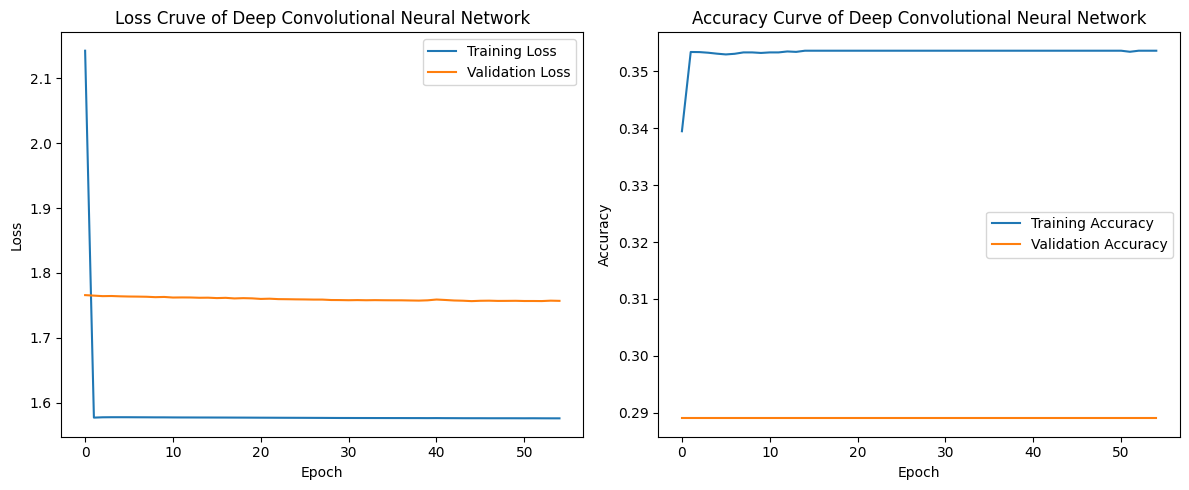

In [ ]:
plot(history6, "Deep Convolutional Neural Network")

# 1D CNN and GRU

In [ ]:
cnn_gru1 = Sequential([
    Embedding(input_dim=len(amino_dict), output_dim=32, input_length=50),
    Conv1D(64, kernel_size=2, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    MaxPooling1D(),
    GRU(32),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile the model
cnn_gru1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model with early stopping
history7 = cnn_gru1.fit(encoded_df_train['seq'].tolist(), encoded_df_train['label'].tolist(),
                     epochs=100, batch_size=32,
                     validation_data=(encoded_df_valid['seq'].tolist(), encoded_df_valid['label'].tolist()),
                     callbacks=[early_stopping])

Epoch 1/100
1676/1676 [==============================] - 39s 21ms/step - loss: 1.6837 - accuracy: 0.3466 - val_loss: 1.7086 - val_accuracy: 0.2890
Epoch 2/100
1676/1676 [==============================] - 33s 20ms/step - loss: 1.5470 - accuracy: 0.3529 - val_loss: 1.7118 - val_accuracy: 0.2890
Epoch 3/100
1676/1676 [==============================] - 43s 26ms/step - loss: 1.5278 - accuracy: 0.3519 - val_loss: 1.7153 - val_accuracy: 0.2886
Epoch 4/100
1676/1676 [==============================] - 57s 34ms/step - loss: 1.5115 - accuracy: 0.3520 - val_loss: 1.6855 - val_accuracy: 0.2890
Epoch 5/100
1676/1676 [==============================] - 58s 34ms/step - loss: 1.5053 - accuracy: 0.3550 - val_loss: 1.6438 - val_accuracy: 0.2978
Epoch 6/100
1676/1676 [==============================] - 38s 22ms/step - loss: 1.5012 - accuracy: 0.3566 - val_loss: 1.6471 - val_accuracy: 0.3093
Epoch 7/100
1676/1676 [==============================] - 33s 20ms/step - loss: 1.4942 - accuracy: 0.3576 - val_loss: 1

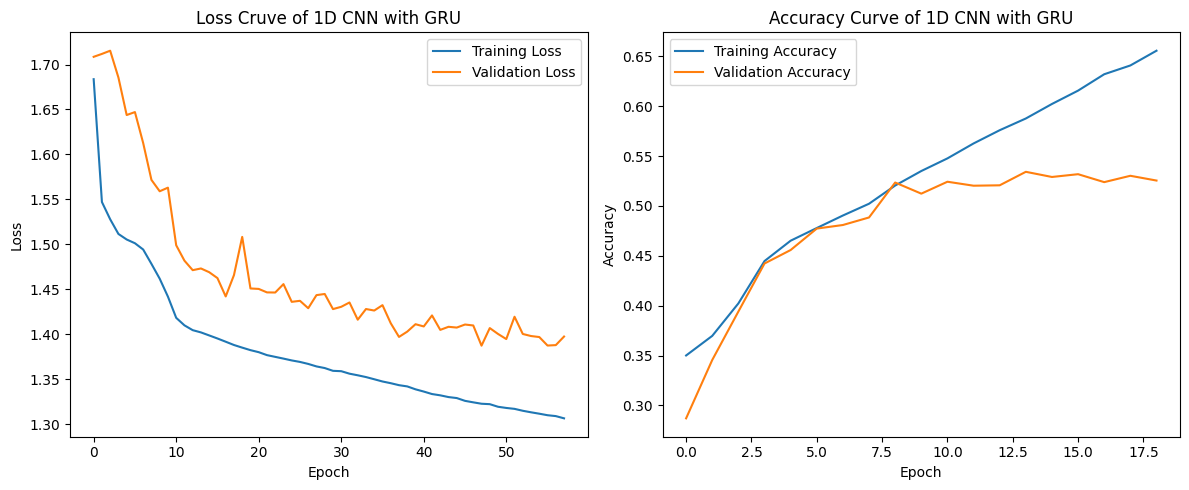

In [ ]:
plot(history7, "1D CNN with GRU")

# Deeper GRU with Regularization

Do not run because training accuracy is very bad and it does not increase.

In [ ]:
# len(amino_dict) = vocab_size
# input_length = max_length
gru2 = Sequential([
    Embedding(input_dim=len(amino_dict), output_dim=32, input_length=50),
    GRU(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile the model
gru2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model with early stopping
history8 = gru2.fit(encoded_df_train['seq'].tolist(), encoded_df_train['label'].tolist(),
                     epochs=100, batch_size=32,
                     validation_data=(encoded_df_valid['seq'].tolist(), encoded_df_valid['label'].tolist()),
                     callbacks=[early_stopping])

Epoch 1/100
1676/1676 [==============================] - 112s 65ms/step - loss: 1.5668 - accuracy: 0.3493 - val_loss: 1.6802 - val_accuracy: 0.2890
Epoch 2/100
1676/1676 [==============================] - 107s 64ms/step - loss: 1.5145 - accuracy: 0.3500 - val_loss: 1.7331 - val_accuracy: 0.2098
Epoch 3/100
1676/1676 [==============================] - 101s 60ms/step - loss: 1.5035 - accuracy: 0.3536 - val_loss: 1.6455 - val_accuracy: 0.2803
Epoch 4/100
1676/1676 [==============================] - 100s 60ms/step - loss: 1.4966 - accuracy: 0.3589 - val_loss: 1.6558 - val_accuracy: 0.2906
Epoch 5/100
1676/1676 [==============================] - 100s 60ms/step - loss: 1.4896 - accuracy: 0.3660 - val_loss: 1.6401 - val_accuracy: 0.2854
Epoch 6/100
1676/1676 [==============================] - 98s 59ms/step - loss: 1.4850 - accuracy: 0.3683 - val_loss: 1.6189 - val_accuracy: 0.2950
Epoch 7/100
1676/1676 [==============================] - 105s 63ms/step - loss: 1.4792 - accuracy: 0.3716 - val_l

KeyboardInterrupt: 

# LSTM with Regularization

In [ ]:
# len(amino_dict) = vocab_size
# input_length = max_length
lstm2 = Sequential([
    Embedding(input_dim=len(amino_dict), output_dim=32, input_length=50),
    LSTM(128),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile the model
lstm2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model with early stopping
history9 = lstm2.fit(encoded_df_train['seq'].tolist(), encoded_df_train['label'].tolist(),
                     epochs=100, batch_size=32,
                     validation_data=(encoded_df_valid['seq'].tolist(), encoded_df_valid['label'].tolist()),
                     callbacks=[early_stopping])

Epoch 1/100
1676/1676 [==============================] - 128s 75ms/step - loss: 1.5145 - accuracy: 0.3492 - val_loss: 1.6518 - val_accuracy: 0.2874
Epoch 2/100
1676/1676 [==============================] - 127s 76ms/step - loss: 1.4321 - accuracy: 0.3725 - val_loss: 1.4413 - val_accuracy: 0.3455
Epoch 3/100
1676/1676 [==============================] - 125s 75ms/step - loss: 1.3774 - accuracy: 0.3993 - val_loss: 1.3864 - val_accuracy: 0.3762
Epoch 4/100
1676/1676 [==============================] - 126s 75ms/step - loss: 1.3358 - accuracy: 0.4298 - val_loss: 1.3269 - val_accuracy: 0.4455
Epoch 5/100
1676/1676 [==============================] - 124s 74ms/step - loss: 1.3022 - accuracy: 0.4496 - val_loss: 1.3069 - val_accuracy: 0.4566
Epoch 6/100
1676/1676 [==============================] - 125s 75ms/step - loss: 1.2757 - accuracy: 0.4644 - val_loss: 1.2907 - val_accuracy: 0.4693
Epoch 7/100
1676/1676 [==============================] - 125s 75ms/step - loss: 1.2509 - accuracy: 0.4711 - val_

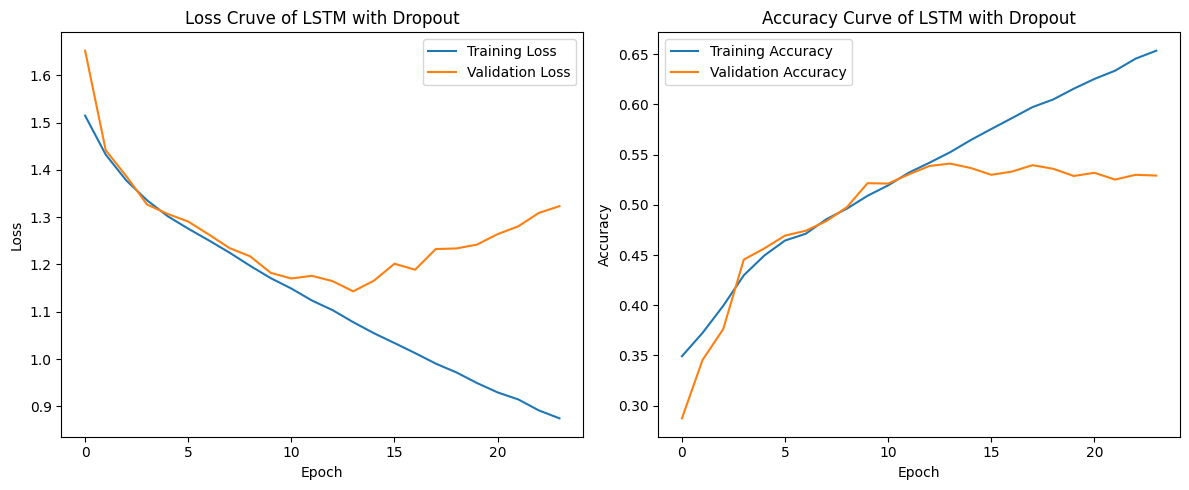

In [ ]:
plot(history9, "LSTM with Dropout")

# Test Set

In [ ]:
len(encoded_df_test['label'])

12851

In [ ]:
y_pred_dnn2 = dnn2.predict(np.array(encoded_df_test['seq'].tolist()))

402/402 [==============================] - 2s 5ms/step


In [ ]:
y_pred_argmax_dnn2 = []
sum1 = 0
for i in range(len(y_pred_dnn2)):
    y_pred_argmax_dnn2.append(np.argmax(y_pred_dnn2[i]))
    if y_pred_argmax_dnn2[i] == encoded_df_test['label'][i]:
      sum1 += 1

In [ ]:
print("Accuracy is ", sum1/len(encoded_df_test['label']) * 100, "%")

Accuracy is  15.500739242082329 %


In [ ]:
y_pred_lstm2 = lstm2.predict(np.array(encoded_df_test['seq'].tolist()))

402/402 [==============================] - 13s 32ms/step


In [ ]:
y_pred_argmax_lstm2 = []
sum2 = 2
for i in range(len(y_pred_lstm2)):
    y_pred_argmax_lstm2.append(np.argmax(y_pred_lstm2[i]))
    if y_pred_argmax_lstm2[i] == encoded_df_test['label'][i]:
      sum2 += 1

In [ ]:
print("Accuracy is ", sum2/len(encoded_df_test['label']) * 100, "%")

Accuracy is  51.14777060150961 %


In [ ]:
y_pred_gru1 = gru1.predict(np.array(encoded_df_test['seq'].tolist()))

402/402 [==============================] - 6s 16ms/step


In [ ]:
y_pred_argmax_gru1 = []
sum3 = 0
for i in range(len(y_pred_gru1)):
    y_pred_argmax_gru1.append(np.argmax(y_pred_gru1[i]))
    if y_pred_argmax_gru1[i] == encoded_df_test['label'][i]:
      sum3 += 1

In [ ]:
print("Accuracy is ", sum3/len(encoded_df_test['label']) * 100, "%")

Accuracy is  43.73200529141701 %


In [ ]:
y_pred_cnn1 = cnn1.predict(np.array(encoded_df_test['seq'].tolist()))

402/402 [==============================] - 1s 3ms/step


In [ ]:
y_pred_argmax_cnn1 = []
sum4 = 0
for i in range(len(y_pred_cnn1)):
    y_pred_argmax_cnn1.append(np.argmax(y_pred_cnn1[i]))
    if y_pred_argmax_cnn2[i] == encoded_df_test['label'][i]:
      sum4 += 1

In [ ]:
print("Accuracy is ", sum4/len(encoded_df_test['label']) * 100, "%")

Accuracy is  10.699556454750603 %
